In [1]:
import kaggle
import os
import segmentation_models_pytorch as smp
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import cv2


from PIL import Image
from albumentations.pytorch import ToTensorV2
from kaggle.api.kaggle_api_extended import KaggleApi
from torch.utils.data import Dataset
from tqdm import tqdm
from torchvision import transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
api = KaggleApi()
api.authenticate()
api.model_list_cli()

# Download the dataset
if os.path.exists('dataset/RGB_color_image_masks'):
    print('Dataset already downloaded')
else:
    api.dataset_download_files('bulentsiyah/semantic-drone-dataset')

Next Page Token = CfDJ8GYiNaMVVSVCnegdIdgHCPOEdkFpLOUZDAd5znHQxQZj68PDi97CIFt3bCW7X02o_MMtPOxcpzXiSpVIg2ub9M4
   id  ref                                                       title                                             subtitle                                                                                                                                                                                                        author              
-----  --------------------------------------------------------  ------------------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  ------------------  
 3301  google/gemma                                              Gemma                                             Gemma is a family of lightweight, open models built from the research and technology th

In [68]:
segmentation_train_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
    #A.GaussNoise(var_limit=(5, 20), p=0.5),
    #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25, p=0.5),
    #A.Blur(blur_limit=3, p=0.5),
    #A.RandomGamma(p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    #A.ElasticTransform(alpha=1.0, sigma=50.0, alpha_affine=50.0, p=0.5),
    #A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    #A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3, p=0.5),
    #A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.5),
    ToTensorV2(),
])

# pytorch transforms
segmentation_valtest_transform = A.Compose([
    ToTensorV2(),
])

In [69]:
path_img = './dataset/original_images/'
path_mask = './dataset/label_images_semantic/'

name = []
for filename in os.listdir(path_img):
    if os.path.isfile(os.path.join(path_img, filename)):
        name.append(os.path.splitext(filename)[0])

df = pd.DataFrame({'name': name}, index=np.arange(0, len(name)))
df

name
0    316
1    303
2    517
3    310
4    376
..   ...
395  077
396  545
397  171
398  479
399  263

[400 rows x 1 columns]

In [5]:
classes = pd.read_csv('dataset/class_dict_seg.csv', sep=',')
num_classes = len(classes)
classes

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

In [324]:
class ImagePatchDataset(Dataset):
    def __init__(self, img_dir, mask_dir, patch_size=(512, 512), overlap=0, transform=None, use_torch=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.patch_size = patch_size
        self.overlap = overlap
        self.img_files = os.listdir(img_dir)
        self.transform = transform
        self.use_torch = use_torch

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        mask_path = os.path.join(self.mask_dir, self.img_files[idx].replace('.jpg', '.png'))
        
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            raise ValueError(f"Could not load image or mask for {self.img_files[idx]}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if img.shape[:2] != mask.shape[:2]:
            raise ValueError(f"Image and mask sizes do not match for {self.img_files[idx]}")

        if self.use_torch:
            img_patches, mask_patches = self.create_patches_torch(img, mask)
        else:
            img_patches, mask_patches = self.create_patches_numpy(img, mask)

        if self.transform:
            img_patches, mask_patches = self.apply_transform(img_patches, mask_patches)

        if self.use_torch:
            return img_patches, mask_patches
        else:
            img_patches = torch.from_numpy(img_patches).permute(0, 3, 1, 2).float() / 255.0
            mask_patches = torch.from_numpy(mask_patches).long()
            return img_patches, mask_patches

    def create_patches_numpy(self, img, mask):
        patch_height, patch_width = self.patch_size
        stride_height = patch_height - self.overlap
        stride_width = patch_width - self.overlap

        img_patches = self.extract_patches(img, patch_height, patch_width, stride_height, stride_width)
        mask_patches = self.extract_patches(mask, patch_height, patch_width, stride_height, stride_width, is_mask=True)

        return img_patches, mask_patches

    def extract_patches(self, img, patch_height, patch_width, stride_height, stride_width, is_mask=False):
        height, width = img.shape[:2]
        pad_height = (patch_height - height % stride_height) % patch_height
        pad_width = (patch_width - width % stride_width) % patch_width

        img_padded = np.pad(img, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0) if not is_mask else \
                     np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

        if not is_mask:
            patches = np.lib.stride_tricks.as_strided(
                img_padded,
                shape=((height + pad_height - patch_height) // stride_height + 1, (width + pad_width - patch_width) // stride_width + 1, patch_height, patch_width, img.shape[2]),
                strides=(img_padded.strides[0] * stride_height, img_padded.strides[1] * stride_width, img_padded.strides[0], img_padded.strides[1], img_padded.strides[2]),
                writeable=False
            )
            patches = patches.reshape(-1, patch_height, patch_width, img.shape[2])
        else:
            patches = np.lib.stride_tricks.as_strided(ss
                img_padded,
                shape=((height + pad_height - patch_height) // stride_height + 1, (width + pad_width - patch_width) // stride_width + 1, patch_height, patch_width),
                strides=(img_padded.strides[0] * stride_height, img_padded.strides[1] * stride_width, img_padded.strides[0], img_padded.strides[1]),
                writeable=False
            )
            patches = patches.reshape(-1, patch_height, patch_width)

        return patches

    def create_patches_torch(self, img, mask):
        img_tensor = torch.from_numpy(img).float().permute(2, 0, 1).unsqueeze(0)
        mask_tensor = torch.from_numpy(mask).float().unsqueeze(0).unsqueeze(0)

        img_patches = img_tensor.unfold(2, self.patch_size[0], self.patch_size[0] - self.overlap).unfold(3, self.patch_size[1], self.patch_size[1] - self.overlap)
        mask_patches = mask_tensor.unfold(2, self.patch_size[0], self.patch_size[0] - self.overlap).unfold(3, self.patch_size[1], self.patch_size[1] - self.overlap)

        img_patches = img_patches.contiguous().view(-1, 3, self.patch_size[0], self.patch_size[1])
        mask_patches = mask_patches.contiguous().view(-1, 1, self.patch_size[0], self.patch_size[1])

        return img_patches, mask_patches

    def get_num_patches(self, img_shape):
        H, W = img_shape[:2]
        patch_height, patch_width = self.patch_size
        stride_height = patch_height - self.overlap
        stride_width = patch_width - self.overlap

        num_patches_height = (H - patch_height) // stride_height + 1
        num_patches_width = (W - patch_width) // stride_width + 1

        return num_patches_height, num_patches_width

    def apply_transform(self, img_patches, mask_patches):
        transformed_img_patches = []
        transformed_mask_patches = []

        for img_patch, mask_patch in zip(img_patches, mask_patches):
            if self.use_torch:
                img_patch = img_patch.permute(1, 2, 0).cpu().numpy()
                mask_patch = mask_patch.squeeze().cpu().numpy()

            transformed = self.transform(image=img_patch, mask=mask_patch)
            
            if self.use_torch:
                img_patch = torch.from_numpy(transformed['image']).permute(2, 0, 1).float() / 255.0
                mask_patch = torch.from_numpy(transformed['mask']).long()
            else:
                img_patch = transformed['image']
                mask_patch = transformed['mask']
            
            transformed_img_patches.append(img_patch)
            transformed_mask_patches.append(mask_patch)

        if self.use_torch:
            transformed_img_patches = torch.stack(transformed_img_patches)
            transformed_mask_patches = torch.stack(transformed_mask_patches)
        else:
            transformed_img_patches = np.array(transformed_img_patches)
            transformed_mask_patches = np.array(transformed_mask_patches)
        
        return transformed_img_patches, transformed_mask_patches

    def get_original_image(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img


SyntaxError: invalid syntax. Perhaps you forgot a comma? (267863749.py, line 71)

In [325]:
dataset = ImagePatchDataset(img_dir='dataset/original_images', mask_dir='dataset/label_images_semantic', patch_size=(4000, 6000), overlap=0, transform=segmentation_train_augmentation)

dataloaders = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=8)

Sample 1:
Original image shape: (4000, 6000, 3)
Image patches shape: torch.Size([16, 3, 1000, 1500])
Mask patches shape: torch.Size([16, 1000, 1500])
Sample 2:
Original image shape: (4000, 6000, 3)
Image patches shape: torch.Size([16, 3, 1000, 1500])
Mask patches shape: torch.Size([16, 1000, 1500])
Sample 3:
Original image shape: (4000, 6000, 3)
Image patches shape: torch.Size([16, 3, 1000, 1500])
Mask patches shape: torch.Size([16, 1000, 1500])
Sample 4:
Original image shape: (4000, 6000, 3)
Image patches shape: torch.Size([16, 3, 1000, 1500])
Mask patches shape: torch.Size([16, 1000, 1500])
Sample 5:
Original image shape: (4000, 6000, 3)
Image patches shape: torch.Size([16, 3, 1000, 1500])
Mask patches shape: torch.Size([16, 1000, 1500])


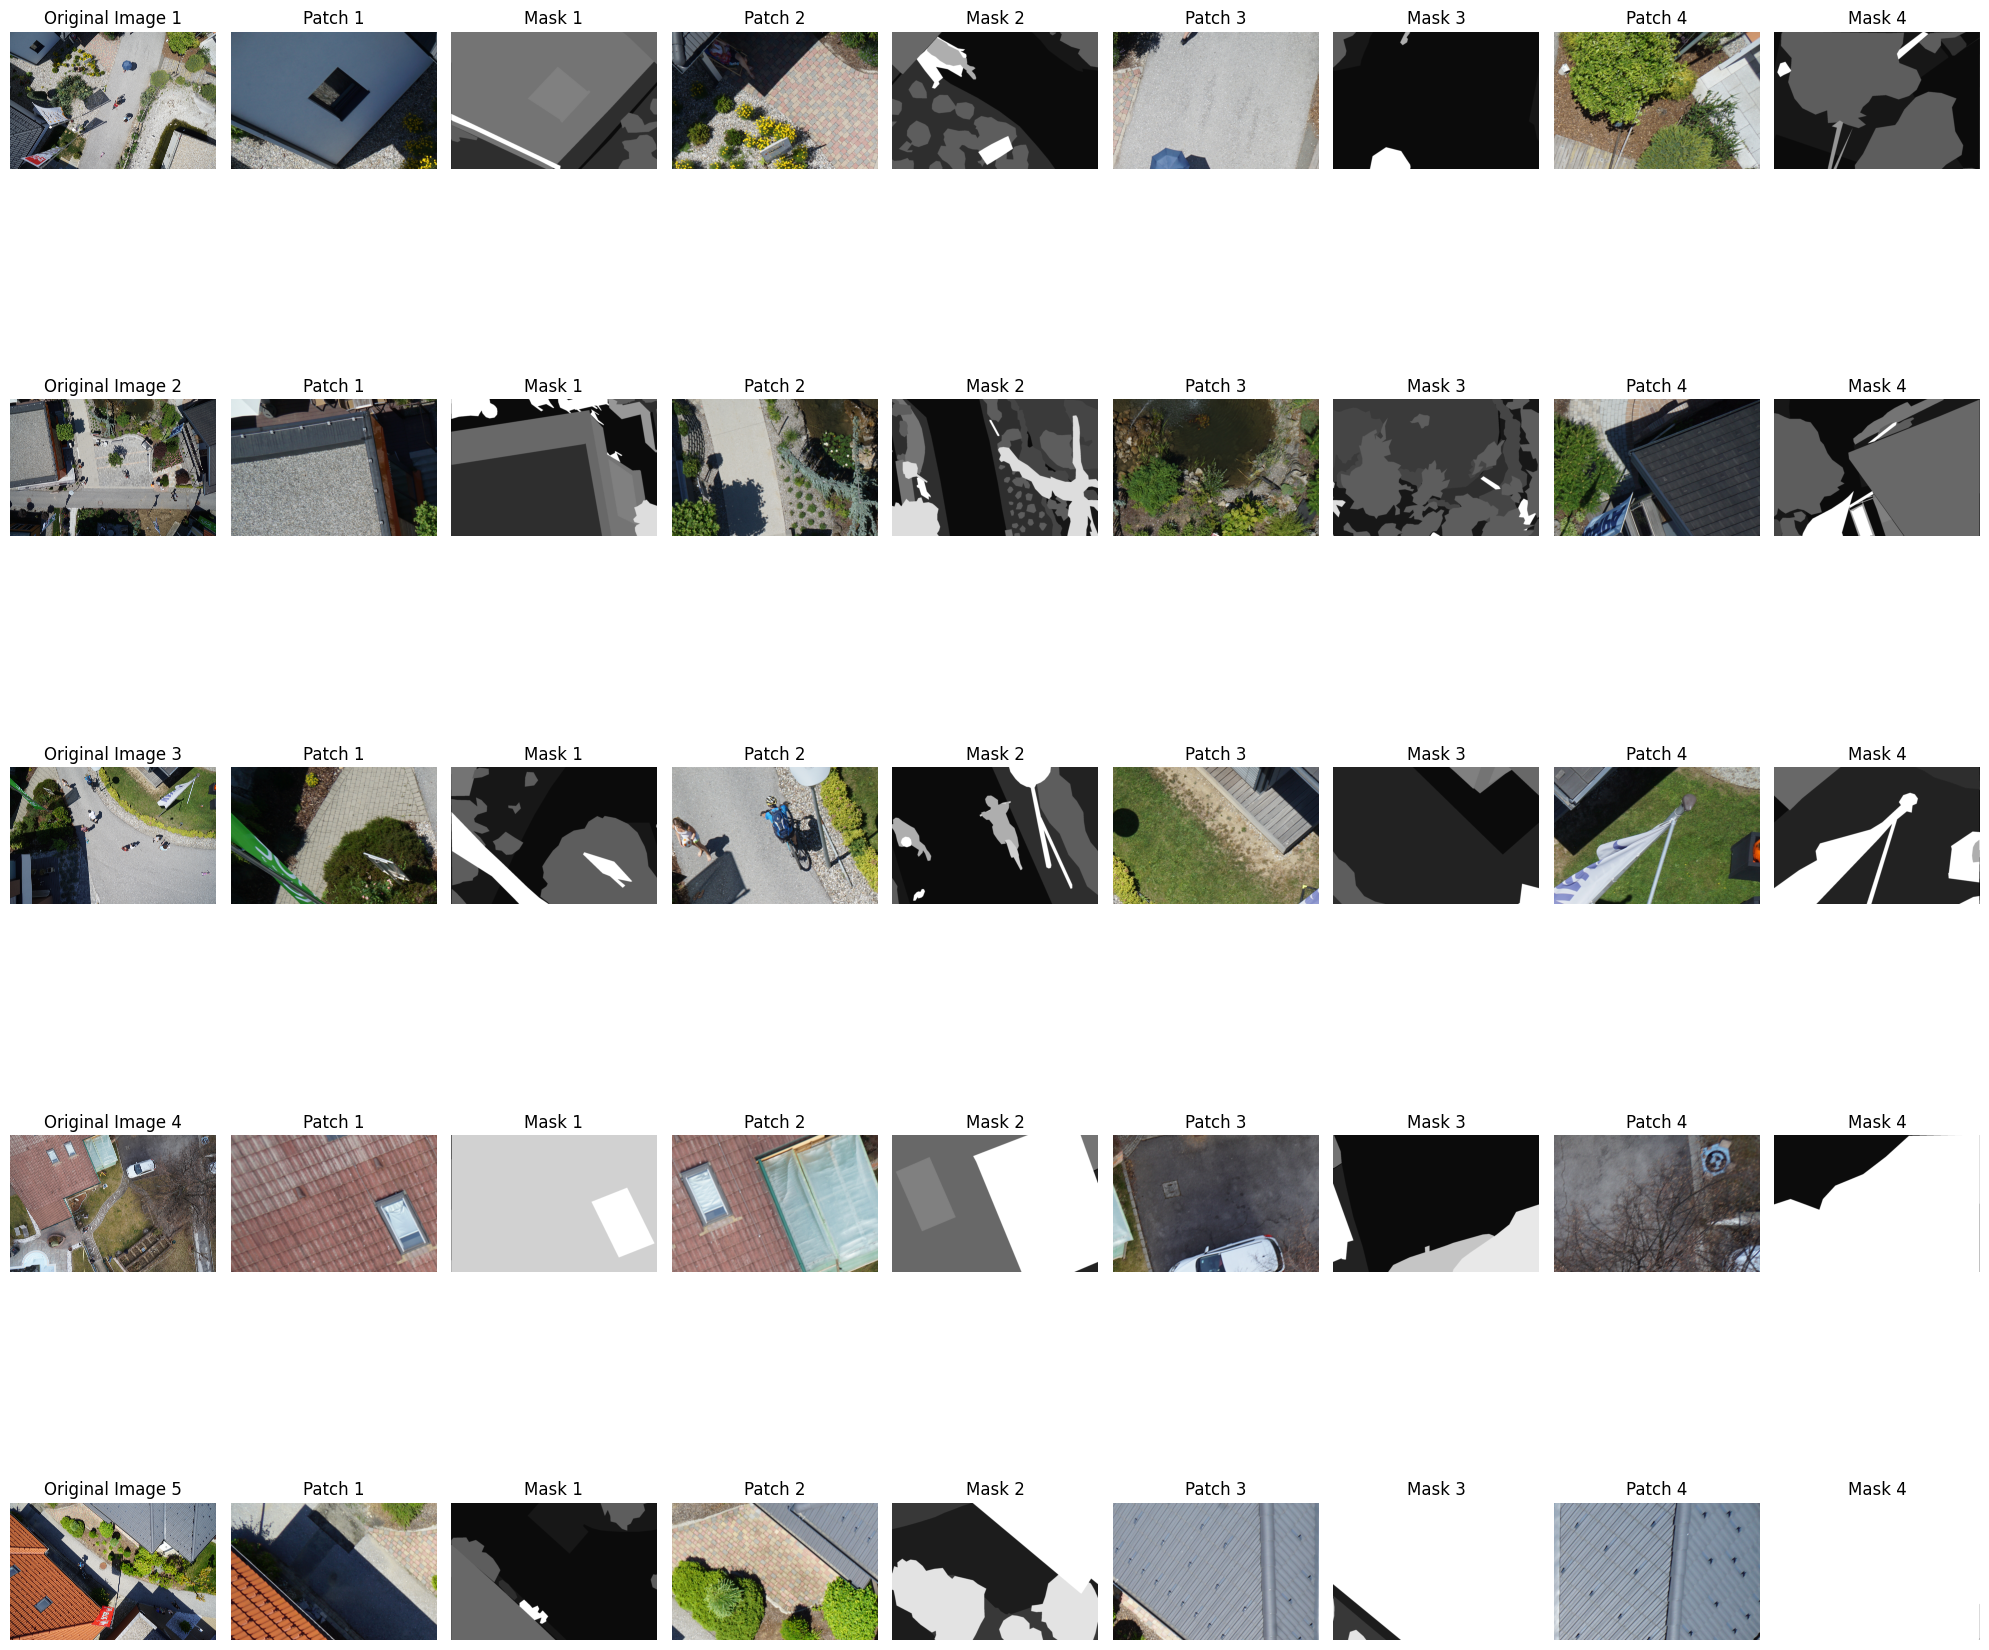

Total number of images in the dataset: 400
Patch size: (1000, 1500)
Number of patches per image: 16
Shape of a single image patch: torch.Size([3, 1000, 1500])
Shape of a single mask patch: torch.Size([1000, 1500])


In [326]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

def visualize_patches(dataset, num_samples=5, patches_per_sample=4):
    fig, axes = plt.subplots(num_samples, patches_per_sample * 2 + 1, figsize=(20, 4 * num_samples))
    
    for sample_idx in range(num_samples):
        # Get the original image and patches for the same index
        original_img = dataset.get_original_image(sample_idx)
        img_patches, mask_patches = dataset[sample_idx]
        
        print(f"Sample {sample_idx + 1}:")
        print(f"Original image shape: {original_img.shape}")
        print(f"Image patches shape: {img_patches.shape}")
        print(f"Mask patches shape: {mask_patches.shape}")
        
        # Display original image
        axes[sample_idx, 0].imshow(original_img)
        axes[sample_idx, 0].set_title(f'Original Image {sample_idx+1}')
        axes[sample_idx, 0].axis('off')
        
        for patch_idx in range(min(patches_per_sample, len(img_patches))):
            img_patch = img_patches[patch_idx]
            mask_patch = mask_patches[patch_idx]
            
            # Transpose image patch if necessary
            if img_patch.shape[0] == 3:  # If in (C, H, W) format
                img_patch = np.transpose(img_patch, (1, 2, 0))
            
            # Normalize image patch for visualization
            img_patch = (img_patch - img_patch.min()) / (img_patch.max() - img_patch.min())
            
            # Display image patch
            axes[sample_idx, patch_idx * 2 + 1].imshow(img_patch)
            axes[sample_idx, patch_idx * 2 + 1].set_title(f'Patch {patch_idx+1}')
            axes[sample_idx, patch_idx * 2 + 1].axis('off')
            
            # Ensure mask is 2D
            if mask_patch.ndim > 2:
                mask_patch = mask_patch.squeeze()
            
            # Display mask patch
            axes[sample_idx, patch_idx * 2 + 2].imshow(mask_patch, cmap='gray')
            axes[sample_idx, patch_idx * 2 + 2].set_title(f'Mask {patch_idx+1}')
            axes[sample_idx, patch_idx * 2 + 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage example
img_dir = 'dataset/original_images/'
mask_dir = 'dataset/label_images_semantic/'
patch_size = (1000, 1500)  # Adjust as needed

# Create the dataset
dataset = ImagePatchDataset(img_dir, mask_dir, patch_size=patch_size)

# Visualize patches
visualize_patches(dataset, num_samples=5, patches_per_sample=4)

# Print some additional information
print(f"Total number of images in the dataset: {len(dataset)}")
print(f"Patch size: {patch_size}")
sample_img_patches, sample_mask_patches = dataset[0]
print(f"Number of patches per image: {len(sample_img_patches)}")
print(f"Shape of a single image patch: {sample_img_patches[0].shape}")
print(f"Shape of a single mask patch: {sample_mask_patches[0].shape}")

In [329]:
import matplotlib.pyplot as plt

def visualize_reconstructed_image(dataset, idx):
    img_patches, _ = dataset[idx]
    
    num_patches_height, num_patches_width = dataset.get_num_patches(dataset.get_original_image(idx).shape)

    patch_height, patch_width = dataset.patch_size
    stride_height = patch_height - dataset.overlap
    stride_width = patch_width - dataset.overlap

    # Create an empty array to hold the reconstructed image
    reconstructed_img = np.zeros((num_patches_height * stride_height + dataset.overlap, 
                                  num_patches_width * stride_width + dataset.overlap, 3), dtype=np.uint8)

    patch_idx = 0
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            y = i * stride_height
            x = j * stride_width
            reconstructed_img[y:y + patch_height, x:x + patch_width] = img_patches[patch_idx]
            patch_idx += 1

    # Add lines between patches
    line_color = (0, 0, 0)  # Red lines
    for i in range(1, num_patches_height):
        y = i * stride_height
        reconstructed_img[y:y+1, :] = line_color

    for j in range(1, num_patches_width):
        x = j * stride_width
        reconstructed_img[:, x:x+1] = line_color

    # Plot the original image and the reconstructed image
    original_img = dataset.get_original_image(idx)

    fig, axs = plt.subplots(1, 2, figsize=(15, 15))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(reconstructed_img)
    axs[1].set_title("Reconstructed Image from Patches")
    axs[1].axis('off')

    plt.show()

visualize_reconstructed_image(dataset, 0)


ValueError: could not broadcast input array from shape (3,1000,1500) into shape (1000,1500,3)

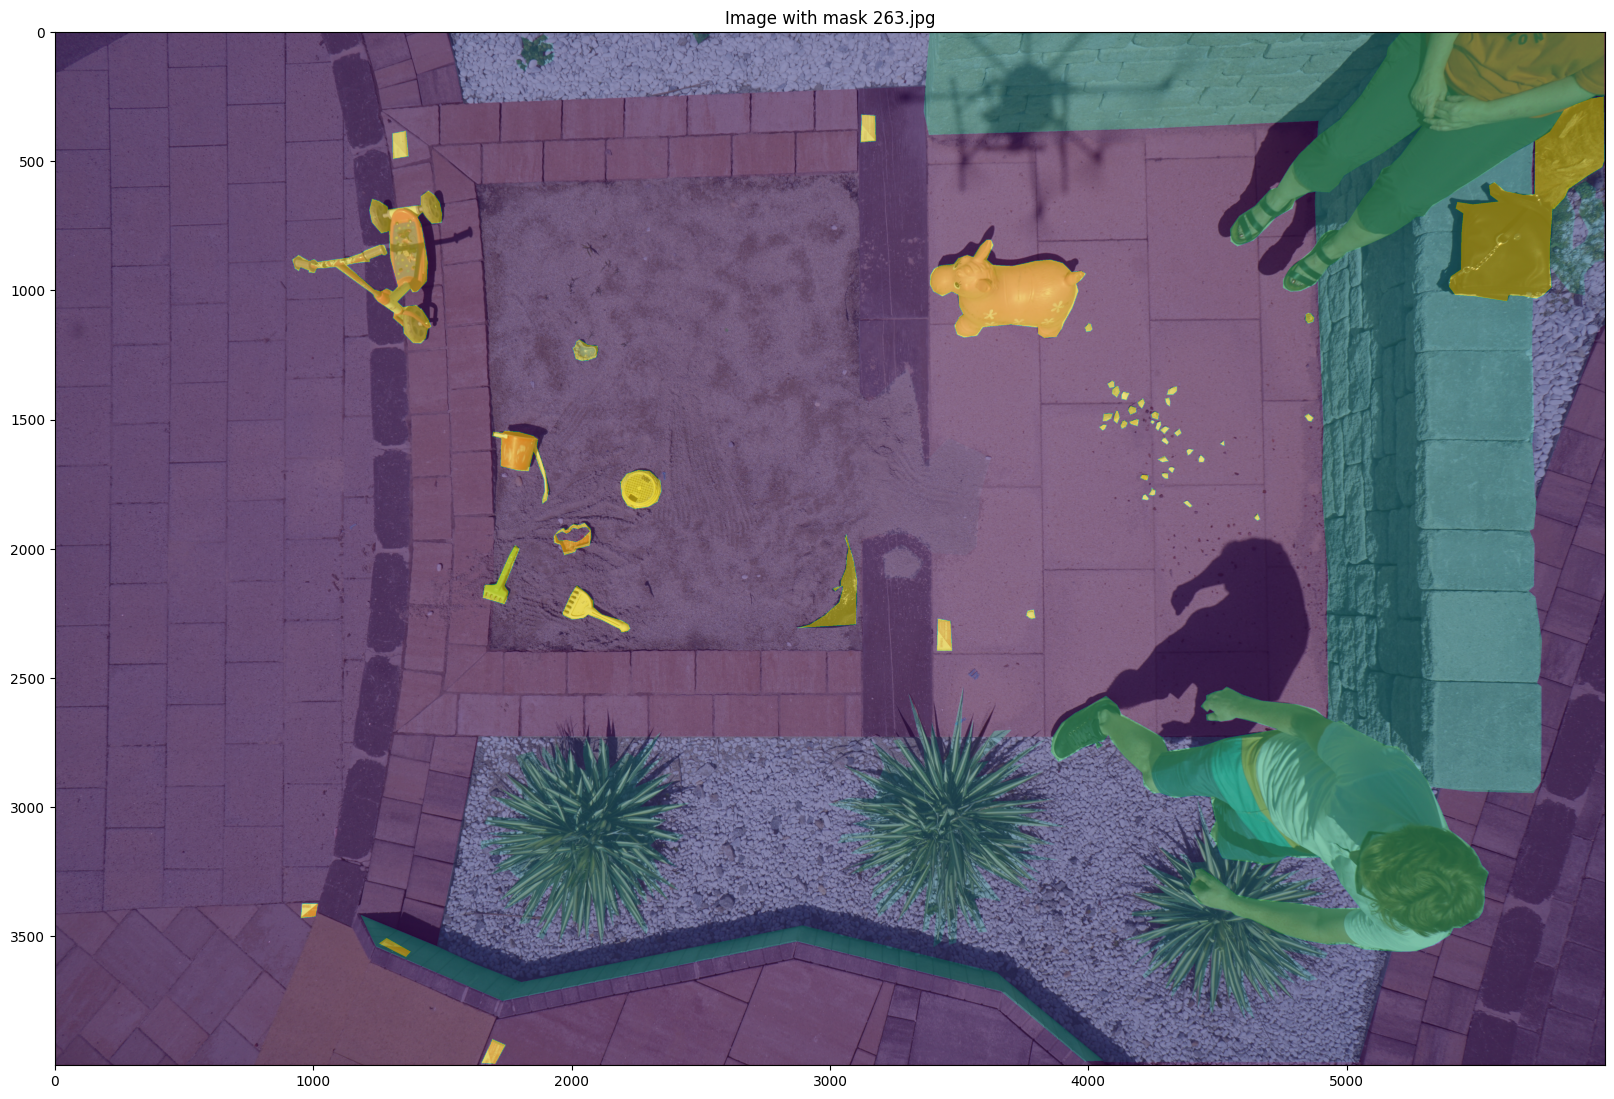

In [ ]:
rnd = np.random.randint(0, len(df))
img = Image.open(os.path.join(path_img, df['name'][rnd] + '.jpg'))
mask = Image.open(os.path.join(path_mask, df['name'][rnd] + '.png'))

plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.title(f'Image with mask {df["name"][rnd]}.jpg')
plt.show()

In [319]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(model, dataset, num_classes, batch_size=4, num_epochs=25, learning_rate=0.001, device='cuda'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for img_patches, mask_patches in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            img_patches = img_patches.to(device)
            mask_patches = mask_patches.to(device)

            optimizer.zero_grad()
            
            img_patches = img_patches.view(-1, *img_patches.shape[2:])
            mask_patches = mask_patches.view(-1, *mask_patches.shape[2:])

            outputs = model(img_patches)
            loss = criterion(outputs, mask_patches)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader)}")

        print("Training complete")
    return model


In [320]:
img_dir = 'dataset/original_images/'
mask_dir = 'dataset/label_images_semantic/'

dataset = ImagePatchDataset(img_dir, mask_dir, patch_size=(512, 512), transform=segmentation_train_augmentation, use_torch=True)

num_classes = 2  # Update this based on your dataset
model = smp.DeepLabV3Plus(
    encoder_name='resnet34',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes
)
model.to(device)


trained_model = train(model, dataset, num_classes, num_epochs=5, device=device)


Epoch 1/5:   0%|          | 0/100 [00:00<?, ?it/s]


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/omirako/.local/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/omirako/.local/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_1302895/672289434.py", line 35, in __getitem__
    img_patches, mask_patches = self.apply_transform(img_patches, mask_patches)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1302895/672289434.py", line 117, in apply_transform
    img_patch = torch.from_numpy(transformed['image']).permute(2, 0, 1).float() / 255.0
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: expected np.ndarray (got Tensor)
